# One-Hot Fully-Connected Model

Using the class-balanced data.

# Imports and Setup


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

Raw data was prepared with a max of 256 words for abstracts and 16 for titles. The insertion of spaces around punctuation increases the effective word count, and exploration shows that nearly all of the data is captured by increasing the seq_len by 50%.

In [1]:
text_field = 'title'
text_encoding = 'tokenized'
assert text_field in ('abstract', 'title'), 'text_field must be one of "title" or "abstract".'
assert text_encoding in ('one-hot', 'tokenized'), 'text_encoding must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if text_encoding == 'one-hot':
    seq_len = 128 if text_field == 'title' else 2048
else:
    seq_len = int(1.5 * 16) if text_field == 'title' else int(1.5 * 256)

Imports and colab setup

In [ ]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
# v1.5.0 of pl breaks wandb sweeps:
# https://github.com/PyTorchLightning/pytorch-lightning/issues/10336
!pip install pytorch-lightning==1.4.9
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

import math
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
pd.set_option(u'float_format', '{:f}'.format)

# pl and wandb installation and setup.
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import wandb

`wandb` log in:

In [ ]:
wandb.login()

wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


True

Google drive access

In [ ]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import models, loaders, and utility functions from an external package:

In [ ]:
import arxiv_vixra_models as avm

Set the model, datamodule, and text decoder to be used (instantianted) in the notebook:

In [ ]:
notebook_model = avm.LitOneHotFC
notebook_datamodule = avm.datamodules.OneHotCharDataCheatingModule
notebook_decoder = avm.one_hot_decoding # one_hot_decoding/ints_to_string for one-hot/embedded text
notebook_wandb_callback = avm.WandbTextCallback

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [ ]:
# GPU. Save availability to is_cuda_available.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  is_cuda_available = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  is_cuda_available = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n",f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
num_processors = cpu_count()

GPU
--------------------------------------------------
 Sat Nov 20 02:47:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Copy data to cwd for speed.

In [ ]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if text_encoding == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif text_field == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .

In [ ]:
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel.

In [ ]:
from requests import get
project_str = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
project_str = project_str.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(project_str)

balanced_title_one_hot_fc_cheating_test


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [ ]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[text_field], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed fromnotebook_model =  val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

42 items removed fromnotebook_model =  val set, 0.558 percent.


Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [ ]:
print(train_data_df.head().to_string())

                                                                                                title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                                          title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [ ]:
model_args_dic = {'seq_len': seq_len,
                  'tokens': tokens_df,
                  'hidden_sizes': [],
                  'dropout_probs': None,
                  'nonlinearity': False
                  }
data_args_dic = {'seq_len': seq_len,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'tokens': tokens_df, 
                 'text_column': text_field,
                 'num_workers': num_processors,
                 'batch_size': 32,
                 'pin_memory': is_cuda_available,
                 'persistent_workers': True
                 }

Small test run.

In [ ]:
small_data_module = notebook_datamodule(**{**data_args_dic, **{'sample_size': .25}})
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for tensor, source in zip(small_inputs[:3], small_targets[:3]):
    stripped_text = notebook_decoder(tensor, tokens_df)
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_model = notebook_model(**model_args_dic)
print('Model layers:', small_model.layers)
small_preds, small_losses = small_model.preds_losses(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape, '\n')
print('\nactual loss:', small_losses.item(), '\n')
print('\nexpected approx loss', -np.log(.5), '\n')

text:                                                                         symmetry principles of the unified field theory : part  
len: 128
source: True
text:                                                                                           on the adjacency spectra of hypertrees
len: 128
source: False
text:                                                                       extended galilean symmetries of non - relativistic strings
len: 128
source: False
Model layers: ModuleList(
  (0): Linear(in_features=8832, out_features=1, bias=True)
)

preds shape: torch.Size([32]) 


actual loss: 0.6977629065513611 


expected approx loss 0.6931471805599453 



/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
small_trainer = Trainer(gpus=-1,max_epochs=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | train_acc               | Accuracy         | 0     
1 | val_acc                 | Accuracy         | 0     
2 | test_acc                | Accuracy         | 0     
3 | train_auc_roc           | AUROC            | 0     
4 | val_auc_roc             | AUROC            | 0     
5 | test_auc_roc            | AUROC            | 0     
6 | train_average_precision | AveragePrecision | 0     
7 | val_average_precision   | AveragePrecision | 0     
8 | test_average_precision  | AveragePrecision | 0     
9 |

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /content/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /content/lr_find_temp_model.ckpt


Suggested lr: 0.13182567385564073


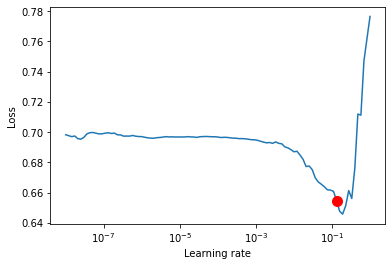

In [ ]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, datamodule=small_data_module, early_stop_threshold=None)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
print(f'Suggested lr: {small_trainer_lr_finder.suggestion()}')

In [ ]:
small_trainer.fit(small_model, datamodule=small_data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | train_acc               | Accuracy         | 0     
1 | val_acc                 | Accuracy         | 0     
2 | test_acc                | Accuracy         | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `fixed_hyper_dic`.
* The hyperparameters chosen by `wandb` from `sweep_config` are merged with those from `fixed_hyper_dic` and passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

In [ ]:
fixed_hyper_dic = {**model_args_dic, **{'save_models_to_wandb': True}}

sweep_config = {'method': 'random'}
sweep_config['early_terminate'] = {'type': 'hyperband',
                                    'min_iter': 3
                                   }
sweep_config['metric'] = {'name': 'best_val_loss',
                           'goal': 'minimize'
                           }
sweep_config['parameters'] =  {'lr': {'value': small_trainer_lr_finder.suggestion()
                                      },                          
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `fixed_hyper_dic` for logging purposes.

In [ ]:
# Setting 'batch_size' in data_args_dic controls the batch size, while setting
# this key in fixed_hyper_dic just lets wandb track this hyperparameter.
data_args_dic['batch_size'] = fixed_hyper_dic['batch_size'] = 4096 #2 **10

# Set max_epochs in a dict, along with any other optional trainer kwargs.
trainer_dic = {'max_epochs': 5,
               'stochastic_weight_avg': True
               }

# Merge trainer_dic into fixed_hyper_dic for logging purposes.
fixed_hyper_dic = {**fixed_hyper_dic, **trainer_dic}

def sweep_iteration():
    group_str = 'linear_models'
    with wandb.init(group=group_str) as run:
        data = notebook_datamodule(**data_args_dic)
        config = wandb.config
        # Merge config into remaining parameters.
        config = {**fixed_hyper_dic, **config}
        model = notebook_model(**config)
        # Taking random samples from the validation set for callback visualization.
        val_sample_module = notebook_datamodule(**{**data_args_dic, **{'sample_size': 512}})
        val_sample_module.setup()
        val_sample  = next(iter(val_sample_module.val_dataloader()))
        # Overwrite th e random run names chosen by wandb.
        run.name = 'no_hiddens'
        trainer = Trainer(
            logger=WandbLogger(),
            gpus=-1 if is_cuda_available else 0,
            log_every_n_steps=5,
            callbacks=[notebook_wandb_callback(val_sample=val_sample,
                                             decoder_fn=notebook_decoder,
                                             translation_data=tokens_df,
                                             labels=('arxiv', 'vixra')),
                       EarlyStopping(monitor='val_loss')
                                             ],
            num_sanity_val_steps=-1,
            **trainer_dic
            )
        trainer.fit(model, datamodule=data)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=project_str)

Create sweep with ID: ajt5nl9t
Sweep URL: https://wandb.ai/garrett361/balanced_title_one_hot_fc_cheating_test/sweeps/ajt5nl9t


wandb: Agent Starting Run: kqap1dw1 with config:
wandb: 	lr: 0.13182567385564073


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | train_acc               | Accuracy         | 0     
1 | val_acc                 | Accuracy         | 0     
2 | test_acc                | Accuracy     

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6937072277069092
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6937072277069092


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.5770566463470459
Validation Loss: 1.3463817834854126


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.874465823173523
Validation Loss: 0.2815500497817993
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.874465823173523
Validation Loss: 0.2815500497817993


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.9699519276618958
Validation Loss: 0.1331108659505844
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.9699519276618958
Validation Loss: 0.1331108659505844


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.9770299196243286
Validation Loss: 0.08655677735805511
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.9770299196243286
Validation Loss: 0.08655677735805511


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.9778311848640442
Validation Loss: 0.07410357892513275
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.9778311848640442
Validation Loss: 0.07410357892513275


best_val_acc,▁▆███
best_val_loss,█▃▂▁▁
epoch,▁▁▃▃▅▅▆▆██
global_step,▁▂▄▅▇█
train_acc,▁▃▆██
train_auc_roc,▁▅▇██
train_average_precision,▁▅▇██
train_loss,█▄▂▁▁
trainer/global_step,▁▁▁▃▃▃▅▅▅▆▆▆██
val_acc,▁▆███
val_auc_roc,▁▆███


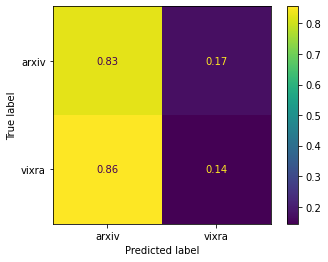

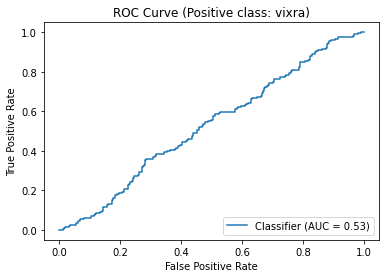

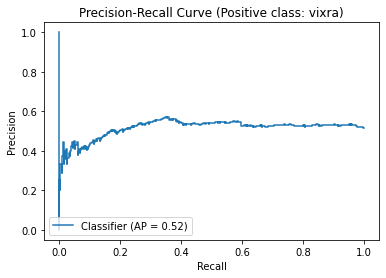

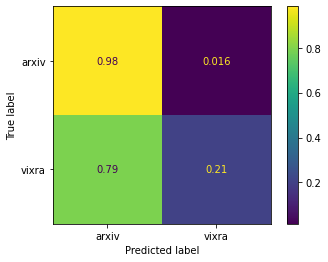

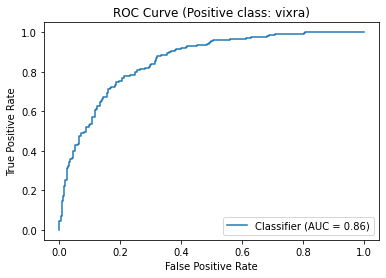

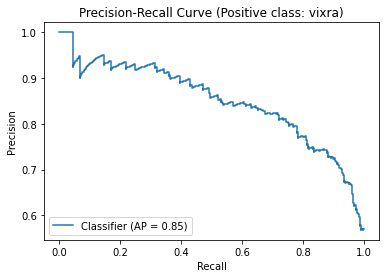

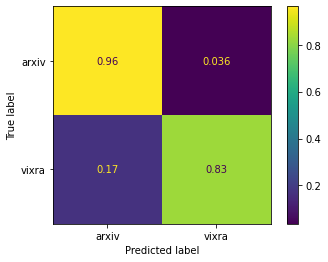

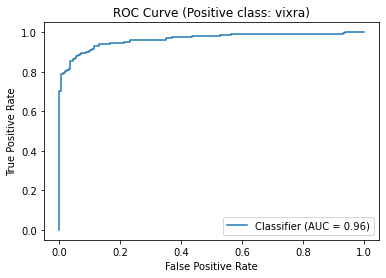

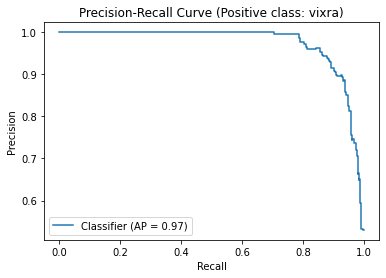

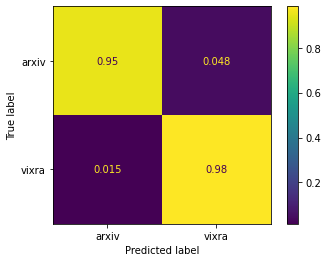

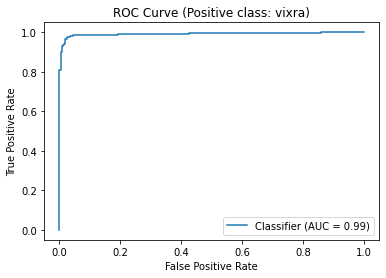

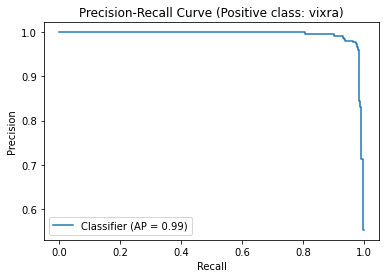

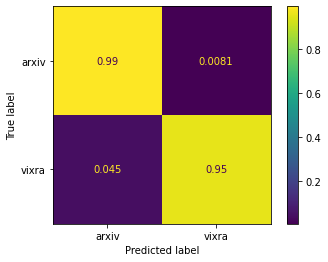

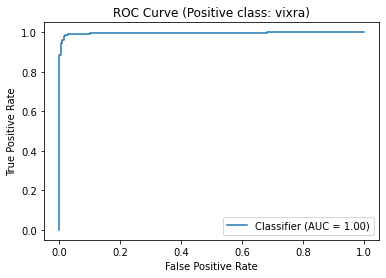

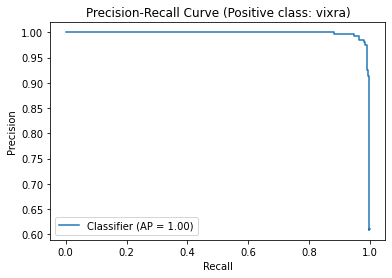

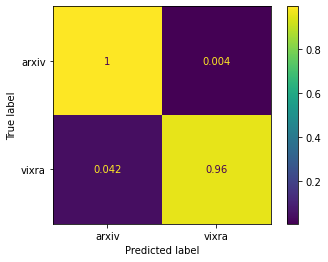

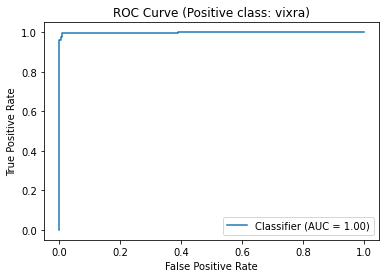

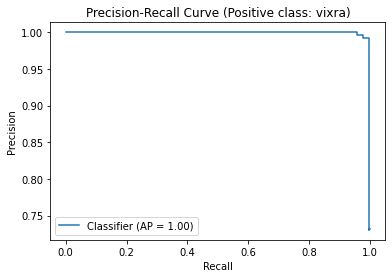

In [ ]:
wandb.agent(sweep_id, function=sweep_iteration, count=1)